In [282]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
from scipy import stats
import gc

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [283]:
data_dir = '/content/drive/MyDrive/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(test_data_path)

/content/drive/MyDrive/aiffel/kaggle_kakr_housing/data/train.csv
/content/drive/MyDrive/aiffel/kaggle_kakr_housing/data/test.csv


# 1. 데이터 살펴보기 

```
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
```

In [284]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [285]:
train.head(1)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650


In [286]:
train.isnull().sum()/train.shape[0]*100

id               0.0
date             0.0
price            0.0
bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
waterfront       0.0
view             0.0
condition        0.0
grade            0.0
sqft_above       0.0
sqft_basement    0.0
yr_built         0.0
yr_renovated     0.0
zipcode          0.0
lat              0.0
long             0.0
sqft_living15    0.0
sqft_lot15       0.0
dtype: float64

In [287]:
test.head(1)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639


In [288]:
test.isnull().sum()/test.shape[0]*100

id               0.0
date             0.0
bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
waterfront       0.0
view             0.0
condition        0.0
grade            0.0
sqft_above       0.0
sqft_basement    0.0
yr_built         0.0
yr_renovated     0.0
zipcode          0.0
lat              0.0
long             0.0
sqft_living15    0.0
sqft_lot15       0.0
dtype: float64

# 2. 변수 시각화 

## Taget Variable

Text(0.5, 1.0, 'Probability Plot of log transformed Price')

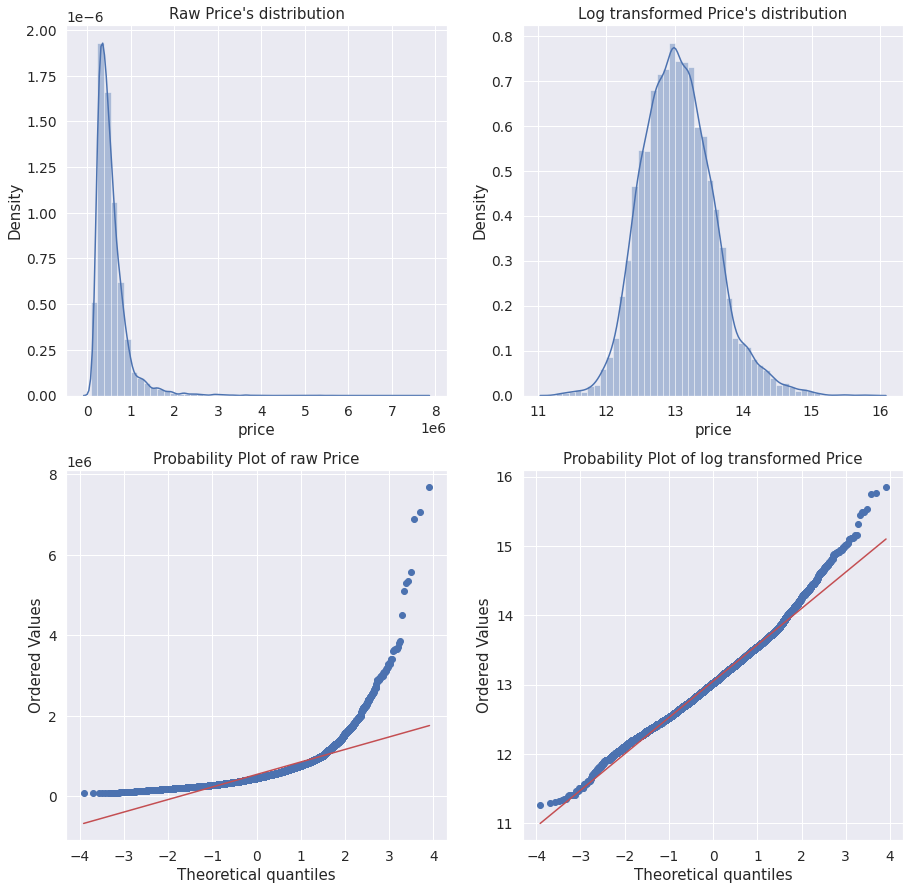

In [289]:
fig = plt.figure(figsize = (15, 15))

fig.add_subplot(2,2,1)
sns.distplot(train['price'])
plt.title('Raw Price\'s distribution')

fig.add_subplot(2,2,2)
sns.distplot(np.log1p(train['price']))
plt.title('Log transformed Price\'s distribution')

fig.add_subplot(2,2,3)
stats.probplot(train['price'], plot=plt)
plt.title('Probability Plot of raw Price')

fig.add_subplot(2,2,4)
stats.probplot(np.log1p(train['price']), plot=plt)
plt.title('Probability Plot of log transformed Price')

> Target 변수인 `price`는 정규분포를 따르지 않고 왼쪽으로 치우진 모양을 하고 있다. 집값 예측에 회귀모형을 사용할 것이기 때문에 로그 변환을 통해 좀 더 정규분포스럽게 바꿔줘야한다. 

In [290]:
# taget variable 로그변환 
train['price'] = np.log1p(train['price'])

## Feature Variable

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


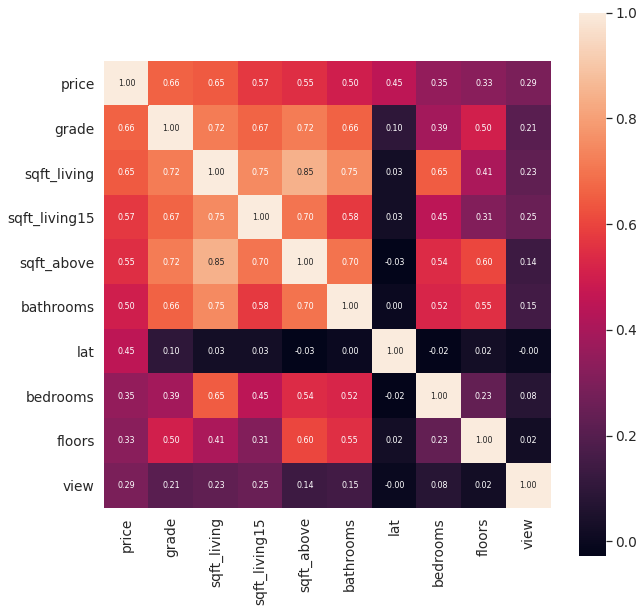

In [291]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
# https://www.kaggle.com/junoindatascience/let-s-eda-it 준호님이 수정해 준 코드로 사용하였습니다. 
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

> Target Variable과 상관도가 높은 상위 10개의 스피어만 순위 상관관계를 보면 `grade`, `sqft_living`, `sqft_living15`, `sqft_above` 순으로 이어진다. 이것을 보면 집의 등급과 집의 크기가 가격을 결정하는 중요한 요인으로 보인다. 

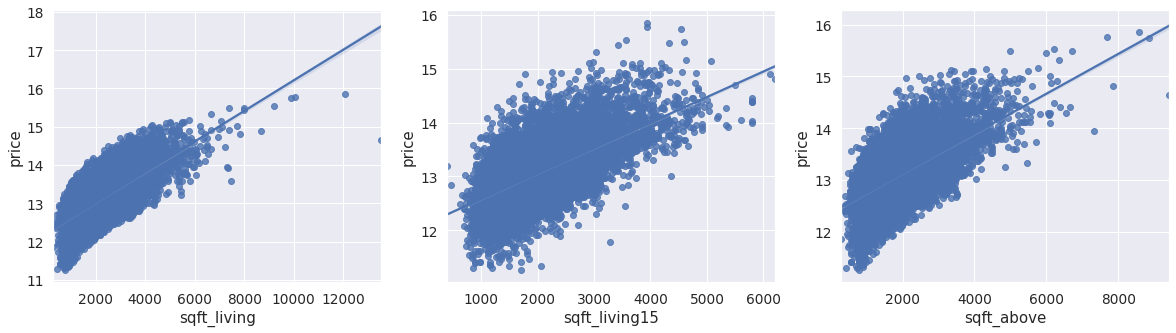

In [292]:
fig = plt.figure(figsize=(20, 5))

fig.add_subplot(1, 3, 1)
concat_data = pd.concat([train['price'], train['sqft_living']], axis=1)
sns.regplot(x='sqft_living', y="price", data=concat_data)

fig.add_subplot(1, 3, 2)
concat_data = pd.concat([train['price'], train['sqft_living15']], axis=1)
sns.regplot(x='sqft_living15', y="price", data=concat_data)

fig.add_subplot(1, 3, 3)
concat_data = pd.concat([train['price'], train['sqft_above']], axis=1)
sns.regplot(x='sqft_above', y="price", data=concat_data)

> plot1. `sqft_living` 선형적으로 보이지만 이상치가 존재한다.
>
> plot2. `sqft_living15` 는 `sqft_living`에 비해 가격의 분산이 크다.
>
> plot3. `sqft_above` 선형적으로 보이지만 이상치가 조금 더 많이 존재한다. 

### Grade <-> Price

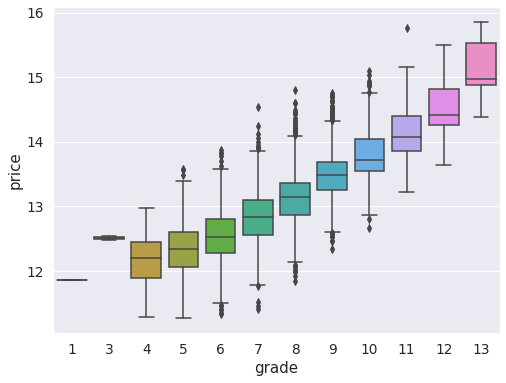

In [293]:
concat_data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=concat_data)

> 등급은 "1-3은 건물 건축 및 디자인에 미치지 못하고 7은 평균 수준의 건축 및 디자인을, 11-13은 높은 수준의 건축 및 디자인을 지니고 있습니다."라고 명시되어 있다.
>
> 등급에 따른 집값 boxplot을 보면 
> * grade 3는 값이 큼
> * grade 7, 8, 9에서 많은 이상치를 보임
> * grade 8, 11에서 차이가 큰 이상치가 나타남의 문제가 생기는데,
> 
> 이 3가지의 문제가 왜 생기는지에 대해선 더 살펴봐야 한다. 

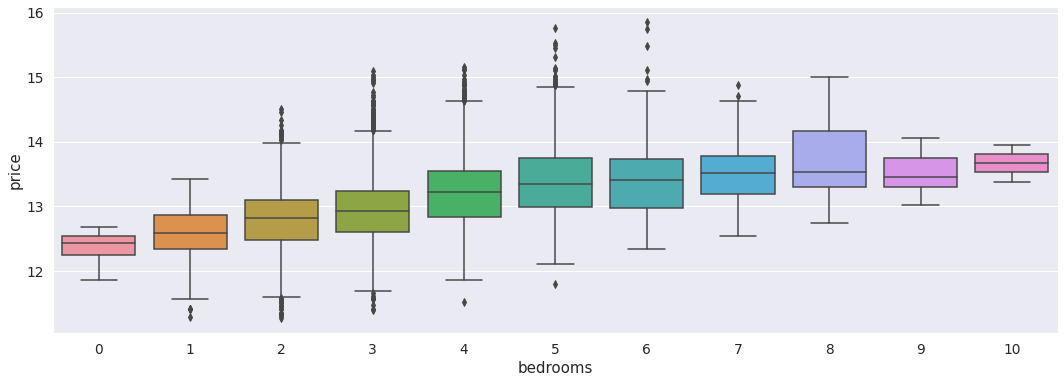

In [294]:
concat_data = pd.concat([train['price'], train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=concat_data)

> `bedrooms` 어느정도 선형관계를 띄고 있다. 
>
> `bedrooms`가 2개 ~ 6개일 때, 방이 적을 때도 집값이 높은 경우가 많이 보이고 있다. 이런 경우는 방의 크기는 작아도 땅값이 비싸 집값이 높은 경우일 것이다. 

# 데이터 전처리 

### SQFT_LIVING

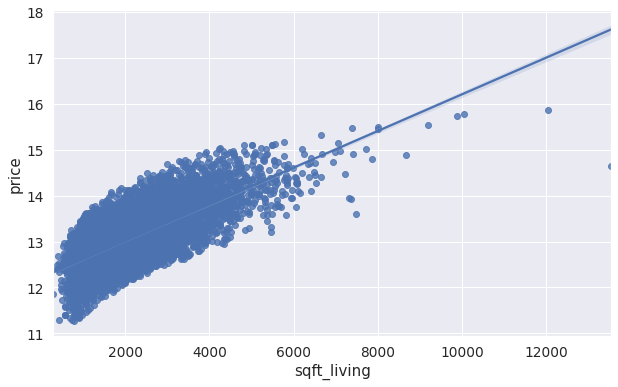

In [295]:
concat_data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.regplot(x='sqft_living', y="price", data=concat_data)

In [296]:
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


> 이상치를 보면 집값은 동일한데 `sqft_living`만 비정상적으로 큰 것을 볼 수 있기 때문에 제거한다. 

In [297]:
train = train.loc[train['id']!=8912]

### GRADE

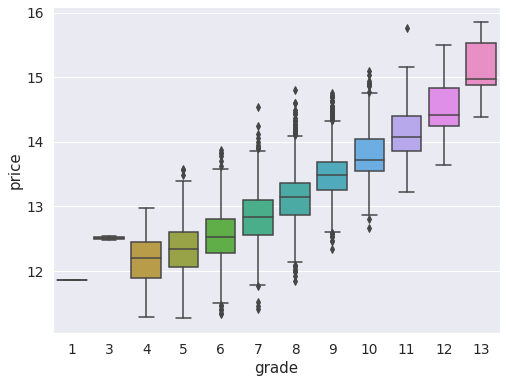

In [298]:
concat_data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=concat_data)

In [299]:
train.loc[(train['price']>12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


> 이상치를 살펴보면 중요한 변수인 `grade`와 `sqft_`변수들도 낮은 것을 볼 수 있기 때문에 이상치로 규정하고 제거한다. 

In [300]:
train.loc[(train['price']>14.7) & (train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [301]:
train.loc[(train['price']>15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [302]:
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]
train = train.loc[train['id']!=7173]
train = train.loc[train['id']!=2775]

### date 변수 정리 


In [303]:
for df in [train,test]:
  df['date'] = df['date'].apply(lambda x: x[0:8])

### 정규화 

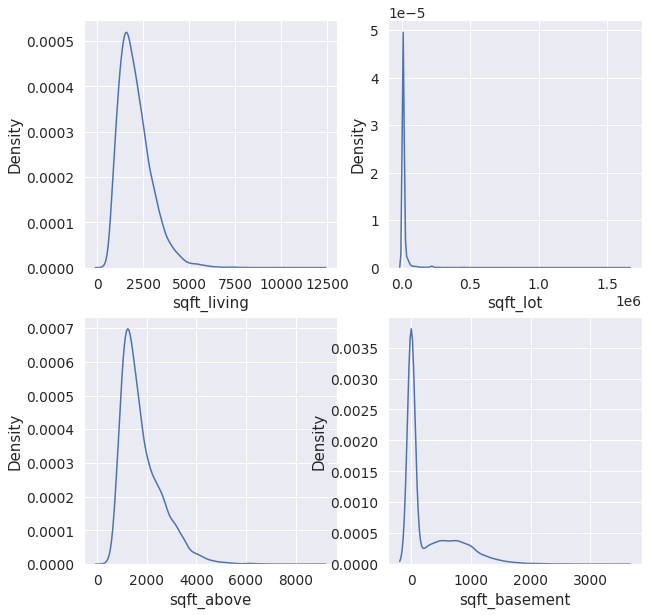

In [304]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

count = 0
for row in range(2):
    for col in range(2):
        if count == 4:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        count+=1

In [305]:
for c in skew_columns:
    train[c] = np.log1p(train[c].values)

In [306]:
for c in skew_columns:
    test[c] = np.log1p(test[c].values)

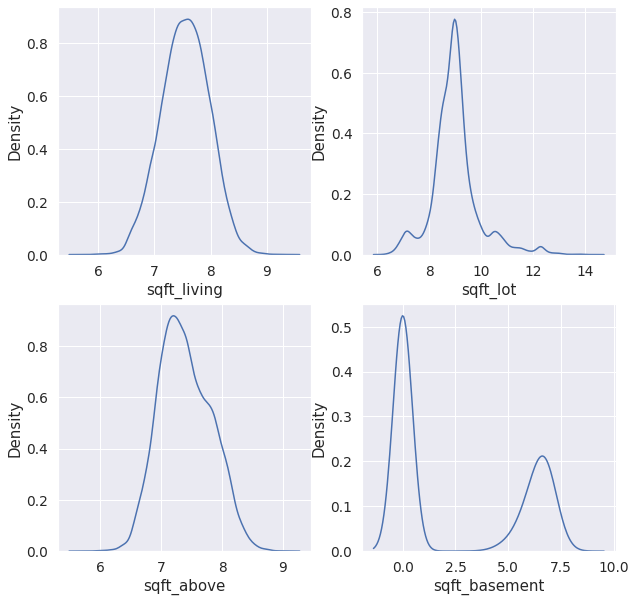

In [307]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

count = 0
for row in range(2):
    for col in range(2):
        if count == 4:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        count+=1

### 변수 생성

In [308]:
for df in [train,test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [309]:
for df in [train,test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

집값의 경우 지역에 영향을 많이 받아 단순 집값이 아닌 평당 가격을 써야함 

In [310]:
train['per_price'] = train['price']/train['sqft_total_size']
zipcode_price = train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
train = pd.merge(train,zipcode_price,how='left',on='zipcode')
test = pd.merge(test,zipcode_price,how='left',on='zipcode')

for df in [train,test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

del train['per_price']

### zipcode 변수 생성

In [311]:
train['zipcode'] = train['zipcode'].astype(str)
test['zipcode'] = test['zipcode'].astype(str)

train['zipcode-3'] = 'z_' + train['zipcode'].str[2:3]
train['zipcode-4'] = 'z_' + train['zipcode'].str[3:4]
train['zipcode-5'] = 'z_' + train['zipcode'].str[4:5]
train['zipcode-34'] = 'z_' + train['zipcode'].str[2:4]
train['zipcode-45'] = 'z_' + train['zipcode'].str[3:5]
train['zipcode-35'] = 'z_' + train['zipcode'].str[2:3] + train['zipcode'].str[4:5]

In [312]:
test['zipcode-3'] = 'z_' + test['zipcode'].str[2:3]
test['zipcode-4'] = 'z_' + test['zipcode'].str[3:4]
test['zipcode-5'] = 'z_' + test['zipcode'].str[4:5]
test['zipcode-34'] = 'z_' + test['zipcode'].str[2:4]
test['zipcode-45'] = 'z_' + test['zipcode'].str[3:5]
test['zipcode-35'] = 'z_' + test['zipcode'].str[2:3] + test['zipcode'].str[4:5]

In [313]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

zip_code = ['zipcode-3', 'zipcode-4', 'zipcode-5', 'zipcode-34', 'zipcode-45', 'zipcode-35']

for zip in zip_code:
    le.fit(train[zip])
    le.fit(test[zip])
    train[zip] = le.transform(train[zip])
    test[zip] = le.transform(test[zip])

In [314]:
zip_g = train[['zipcode', 'price']].groupby('zipcode').mean()

label = [j + 1 for j in range(27)]
zip_g['zip_level'] = pd.cut(zip_g.price, bins=27, labels=label)
zip_g = zip_g.drop(['price'], axis=1)

train = train.merge(zip_g, on='zipcode', how='left')
test = test.merge(zip_g, on='zipcode', how='left')
train.zip_level = train.zip_level.astype(int)
test.zip_level = test.zip_level.astype(int)

In [315]:
del train['zipcode']
del test['zipcode']

### PCA를 통한 변수 추가 

In [316]:
from sklearn.decomposition import PCA

coord = train[['lat','long']]
pca = PCA(n_components=2)
pca.fit(coord)

coord_pca = pca.transform(coord)

train['coord_pca1'] = coord_pca[:, 0]
train['coord_pca2'] = coord_pca[:, 1]

In [317]:
coord = test[['lat','long']]
pca = PCA(n_components=2)
pca.fit(coord)

coord_pca = pca.transform(coord)

test['coord_pca1'] = coord_pca[:, 0]
test['coord_pca2'] = coord_pca[:, 1]

# 모델링

In [318]:
print(train.shape)
print(test.shape)

(15030, 37)
(6468, 36)


In [319]:
train.head(1)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,zipcode_mean,zipcode_var,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35,zip_level,coord_pca1,coord_pca2
0,0,20141013,12.309987,3,1.0,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955.0,47.5112,-122.257,1340,5650,4.0,0.818803,7.074117,1.0,0.237168,0,9.368147,1.214207,1,7,8,16,54,16,3,-0.000982,-0.065753


## Linear Regression

In [320]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

train_columns = [c for c in train.columns if c not in ['id','price','per_price']]

model = sm.OLS(train['price'].values, train[train_columns])
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     3519.
Date:                Tue, 10 Aug 2021   Prob (F-statistic):               0.00
Time:                        11:18:15   Log-Likelihood:                 3973.4
No. Observations:               15030   AIC:                            -7885.
Df Residuals:                   14999   BIC:                            -7649.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
date             5.559e-06   3.44e-07     

> 모델의 설명력은 1로 높지만, 변수들 중 `p-value`가 높은 변수가 존재한다.

다중공선성을 확인해보면 

In [321]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()

vif["Features"] = train.columns
vif["VIF Values"] = [variance_inflation_factor(
    train.values, i) for i in range(train.shape[1])]

vif.sort_values(by='VIF Values',ascending=False)

,Features,VIF Values
36,coord_pca2,inf
33,zipcode-35,inf
22,sqft_total_size,inf
20,total_rooms,inf
30,zipcode-5,inf
17,long,inf
16,lat,inf
13,sqft_basement,inf
12,sqft_above,inf
28,zipcode-3,inf


`waterfront`, `sqft_lot15`, `is_renovated` 3가지 변수를 제외한 모든 변수들에서 다중공선성이 존재한다. 

## LightGBM



In [322]:
y_train = train['price']
X_train = train.drop(['price', 'id'], axis = 1)

sub_id = test['id']
test = test.drop(['id'], axis = 1)


In [323]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [324]:
%%time
dtrain = lgb.Dataset(X_train, label=y_train)
dtest  = lgb.Dataset(test)

lgb_params = {
    'boosting_type': 'gbdt',
    'objective':'regression',
    'num_leave' : 1,
    'learning_rate' : 0.03,
    'max_depth' : 6,
    'colsample_bytree' : 0.4,
    'subsample' : 0.4,
    'max_bin' : 80,
    'gpu_id':0,         
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'refit':True,
    'metric' : 'rmse',
    'seed' : 2019
}

cv_lgb_output = lgb.cv(lgb_params, dtrain, num_boost_round=5000, nfold=5, early_stopping_rounds=200, verbose_eval=100,stratified=False)

print('best_num_rounds :',len(cv_lgb_output['rmse-mean']))
print('best_cv_score :', cv_lgb_output['rmse-mean'][-1])

best_num_rounds = len(cv_lgb_output['rmse-mean'])

model_lgb = lgb.train(lgb_params, dtrain, num_boost_round=best_num_rounds)
lgb_pred_log = model_lgb.predict(test)
lgb_pred = np.expm1(lgb_pred_log)

[100]	cv_agg's rmse: 0.186928 + 0.00423707
[200]	cv_agg's rmse: 0.172165 + 0.00401233
[300]	cv_agg's rmse: 0.168546 + 0.00383496
[400]	cv_agg's rmse: 0.166782 + 0.00386958
[500]	cv_agg's rmse: 0.16573 + 0.00395043
[600]	cv_agg's rmse: 0.165006 + 0.00394117
[700]	cv_agg's rmse: 0.164473 + 0.00394033
[800]	cv_agg's rmse: 0.164145 + 0.0039747
[900]	cv_agg's rmse: 0.16384 + 0.00397007
[1000]	cv_agg's rmse: 0.163653 + 0.00396106
[1100]	cv_agg's rmse: 0.163536 + 0.00395902
[1200]	cv_agg's rmse: 0.16342 + 0.00390661
[1300]	cv_agg's rmse: 0.163373 + 0.00385732
[1400]	cv_agg's rmse: 0.163389 + 0.00378542
[1500]	cv_agg's rmse: 0.163415 + 0.00374993
best_num_rounds : 1308
best_cv_score : 0.16336103245214267
CPU times: user 24.1 s, sys: 1.14 s, total: 25.3 s
Wall time: 13.4 s


In [325]:
def rmse_exp(predictions, dmat):
    labels = dmat.get_label()
    diffs = np.expm1(predictions) - np.expm1(labels)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('rmse_exp', np.sqrt(avg))

## XGBoost

In [326]:
xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.4,
    'objective': 'reg:linear',    
    'eval_metric': 'rmse',        
    'silent': True,               
    'seed' : 1984
}



# transform
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(test)

# cross validation
cv_output = xgb.cv(xgb_params,
                   dtrain,                        
                   num_boost_round=5000,         
                   early_stopping_rounds=150,    
                   nfold=5,                      
                   verbose_eval=100,             
                   feval=rmse_exp,               
                   maximize=False,
                   show_stdv=False,              
                   )

# scoring
best_rounds = cv_output.index.size
score = round(cv_output.iloc[-1]['test-rmse_exp-mean'], 2)

print(f'\nBest Rounds: {best_rounds}')
print(f'Best Score: {score}')

model = xgb.train(xgb_params, dtrain, num_boost_round=best_rounds)
xgb_pred_log = model.predict(dtest)
xgb_pred = np.expm1(xgb_pred_log)

[0]	train-rmse:12.3079	train-rmse_exp:652929	test-rmse:12.3079	test-rmse_exp:652630
[100]	train-rmse:1.6505	train-rmse_exp:554969	test-rmse:1.65129	test-rmse_exp:554900
[200]	train-rmse:0.273934	train-rmse_exp:206998	test-rmse:0.281952	test-rmse_exp:214964
[300]	train-rmse:0.150192	train-rmse_exp:108538	test-rmse:0.169125	test-rmse_exp:131763
[400]	train-rmse:0.137176	train-rmse_exp:89740.7	test-rmse:0.162273	test-rmse_exp:120546
[500]	train-rmse:0.129673	train-rmse_exp:82198.1	test-rmse:0.160092	test-rmse_exp:117052
[600]	train-rmse:0.123665	train-rmse_exp:77204.3	test-rmse:0.15873	test-rmse_exp:115328
[700]	train-rmse:0.118515	train-rmse_exp:73137.1	test-rmse:0.157733	test-rmse_exp:114171
[800]	train-rmse:0.114024	train-rmse_exp:69859.3	test-rmse:0.157071	test-rmse_exp:113467
[900]	train-rmse:0.109868	train-rmse_exp:66882.7	test-rmse:0.156482	test-rmse_exp:112806
[1000]	train-rmse:0.106106	train-rmse_exp:64359.4	test-rmse:0.156094	test-rmse_exp:112320
[1100]	train-rmse:0.102591	train

In [327]:
ensemble_pred = np.vstack([lgb_pred, xgb_pred]).mean(0)
sample_submission_path = join(data_dir, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)
submission = pd.DataFrame(data = {'id': sub_id, 'price': ensemble_pred})
submission.to_csv("submission_7.csv",index=False)

# 회고

데이터 분석이 이렇게 어려운건지 몰랐다. 

진짜 어렵다. 이번 익스는 여러 사람들이 올린 커널을 보고 참고해서 작성했지만 완벽하게 이해하지는 못했다. 

이렇게 많은 참고 자료를 본 것도 처음이다. 데이터 분석을 배웠다고 할 수준도 아니구나를 다시 느꼈다 ^^;

어디가서 나 데이터 분석 할 줄 알아요 라고 말할 수 있는 날이 올때까지 더 열심히 해야겠다!

점수가 오르지 않아 변수들을 여러번에 걸쳐서 하나씩 추가해나갔는데 

여러 커널들을 보면서 흥미로웠던 점은 pca를 활용해 변수를 추가하는 것이었다.

pca로 차원을 축소만 해봤지 그것을 활용해서 변수를 추가한다는 것이 놀라웠다!

그리고 zipcode로 지역 변수를 추가하는 것도 놀랐는데 이런 생각을 했다는 것에 감탄했고 나도 이런 과정을 통해 새로운 인사이트를 얻을 수 있을 날이 언~능 오길 바란다. 



_참고_

https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12

https://www.kaggle.com/rangmar/25th-solution-xgb-lightgbm-ensemble?scriptVersionId=13330020&cellId=19

https://www.kaggle.com/tmheo74/geo-data-eda-and-feature-engineering

https://blog.naver.com/hihello4life/222434972868

https://www.kaggle.com/fulrose/eda-with-map-visualization?scriptVersionId=12681748

https://www.kaggle.com/dhznsdl/house-price-regression-python

https://www.kaggle.com/yeonmin/default-eda-stacking-introduction

https://www.kaggle.com/tmheo74/11th-solution-public-98316-private-99336

https://www.kaggle.com/janged/xgb-lgb
